
Creating splits so that some donors are entirely contained in the test set. This is done for the `singleome` dataset, instead of the `balanced` dataset as was the case in `07_explore_donor_splits.ipynb`. 

In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
from sklearn.model_selection import train_test_split
from schelp.utils.config import load_config
from rich import print as rprint
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

paths = load_config(dataset_key="init")

In [2]:
data_dir = str(paths["data"])
# adata_ = sc.read_h5ad(str(paths["data"]) + '/Human-Brain/balanced_SEAAD_MTG_RNAseq_Singleome_final-nuclei.2024-06-18.h5ad')
adata_ = sc.read(paths["frozen"] / "SEAAD_MTG_RNAseq_Singleome_final-nuclei.2024-02-13.h5ad", backed="r")

In [3]:
print(f"Number of cells: {adata_.shape[0]}")
print(f"Number of supertype categories: {adata_.obs['Supertype'].cat.categories.size}")
print(f"Number of supertype available: {adata_.obs['Supertype'].unique().size}")
print(f"Number of donors: {adata_.obs['Donor ID'].cat.categories.size}")
df = adata_.obs["Overall AD neuropathological Change"].value_counts().to_frame()
df["ratio"] = (df["count"] / df["count"].sum()).round(2)
display(df)

Number of cells: 1226855
Number of supertype categories: 139
Number of supertype available: 139
Number of donors: 89


,count,ratio
Overall AD neuropathological Change,,
High,486272,0.40
Intermediate,296878,0.24
Low,157879,0.13
Not AD,148523,0.12
Reference,137303,0.11


In [4]:
df = adata_.obs[["Overall AD neuropathological Change", "Donor ID", "Supertype"]].copy()


def entropy(x, eps=1e-12):
    p = x.value_counts(normalize=True)
    p = p + eps
    return -np.sum(p * np.log2(p))


df_supertype_entropy = df.groupby("Donor ID")["Supertype"].apply(entropy).sort_values(ascending=False).to_frame()
df_supertype_entropy.columns = ["supertype_entropy"]
df_supertype_entropy.reset_index(inplace=True)

display(df_supertype_entropy.head(3))
display(df_supertype_entropy.tail(3))

,Donor ID,supertype_entropy
0,H21.33.003,5.974542
1,H21.33.002,5.958524
2,H19.33.004,5.939151


,Donor ID,supertype_entropy
86,H21.33.034,4.728466
87,H20.33.038,3.856629
88,H21.33.020,2.440756


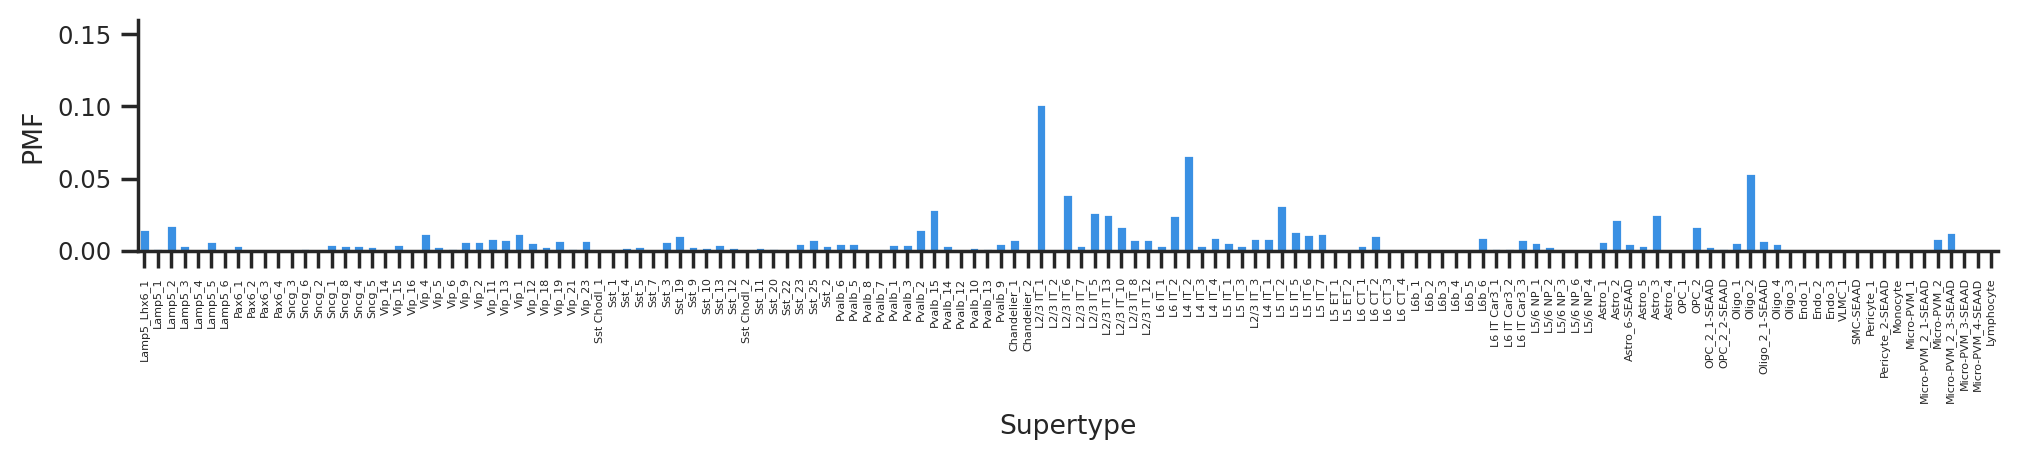

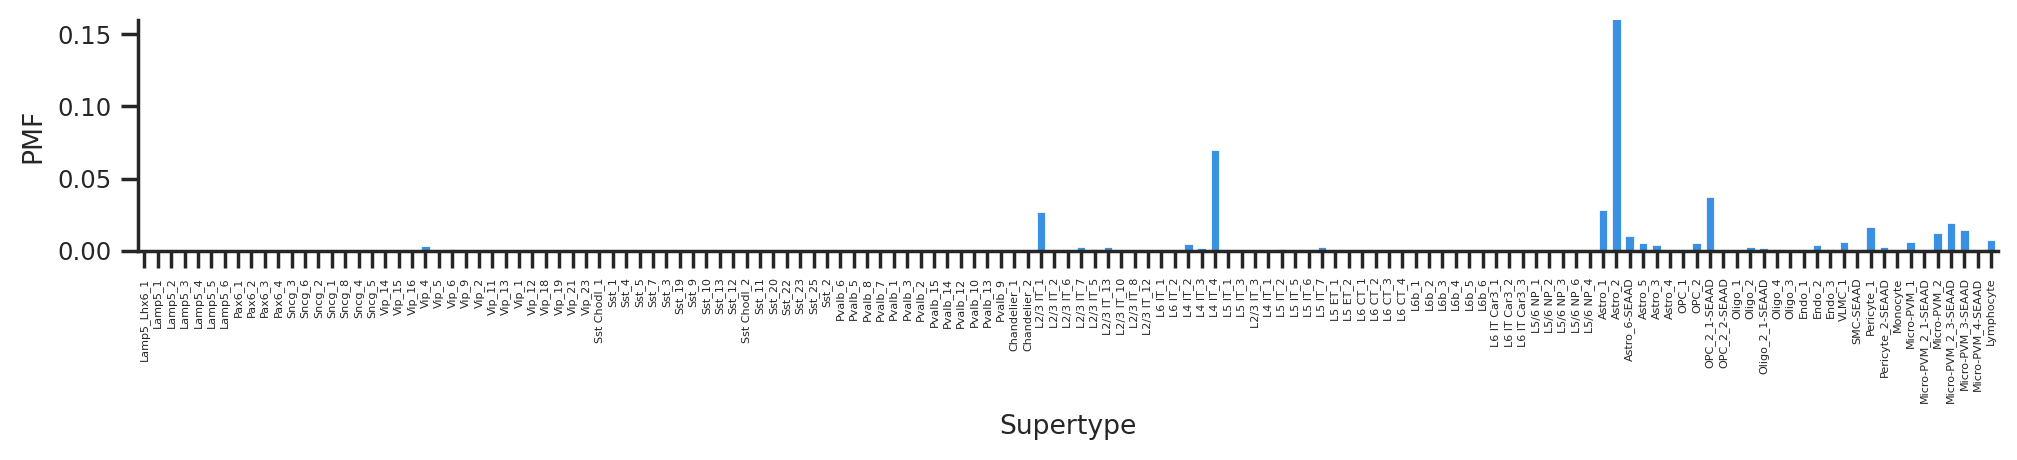

In [5]:
# Donors according to entropy in supertype distribution
high_ent = df_supertype_entropy.iloc[0]["Donor ID"]
low_ent = df_supertype_entropy.iloc[-1]["Donor ID"]

for donor in [high_ent, low_ent]:
    df_ = df[df["Donor ID"] == donor]["Supertype"].value_counts().to_frame()
    df_ = df_.reindex(adata_.obs["Supertype"].cat.categories)
    df_["pmf"] = df_["count"] / df_["count"].sum()
    df_ = df_.reset_index().rename(columns={"index": "Supertype"})

    fig, ax = plt.subplots(figsize=(12, 1.5))
    sns.barplot(data=df_, x="Supertype", y="pmf", ax=ax, color="dodgerblue")
    ax.set(xlabel="Supertype", ylabel="PMF", ylim=[0, 0.16])
    plt.xticks(rotation=90, fontsize=4)
    plt.show()

In [6]:
df_ = df[["Overall AD neuropathological Change", "Donor ID"]].drop_duplicates()
df_.reset_index(drop=True, inplace=True)

# Merge df_ and df_supertype_entropy on Donor ID
df_ = df_.merge(df_supertype_entropy, on="Donor ID")

# sort by "supertype_entropy" and "Overall AD neuropathological Change"
df_ = df_.sort_values(by=["Overall AD neuropathological Change", "supertype_entropy"], ascending=[True, False])
display(df_)

,Overall AD neuropathological Change,Donor ID,supertype_entropy
22,Reference,H19.30.001,5.841219
33,Reference,H19.30.002,5.833992
42,Reference,H18.30.002,5.817611
60,Reference,H18.30.001,5.418838
49,Reference,H200.1023,5.228873
...,...,...,...
15,High,H20.33.046,5.215489
38,High,H20.33.028,5.108018
85,High,H21.33.034,4.728466
87,High,H20.33.038,3.856629


In [7]:
# find the top 15% of donors donors with the most entropy of supertypes within each in each value of 'Overall AD neuropathological Change'
df_test = (
    df_.groupby("Overall AD neuropathological Change")[df_.columns]
    .apply(lambda x: x.nlargest(int(len(x) * 0.15), "supertype_entropy"), include_groups=True)
    .reset_index(drop=True)
)
display(df_test)

,Overall AD neuropathological Change,Donor ID,supertype_entropy
0,Not AD,H21.33.003,5.974542
1,Low,H21.33.043,5.874618
2,Intermediate,H21.33.022,5.890572
3,Intermediate,H21.33.014,5.867396
4,Intermediate,H21.33.025,5.863342
5,High,H21.33.002,5.958524
6,High,H20.33.017,5.888227
7,High,H20.33.026,5.880219
8,High,H21.33.007,5.878059
9,High,H20.33.030,5.852354


In [8]:
# get total number of cells per donor in df, and merge results with the df_test
df_total_cells = df.groupby("Donor ID").size().to_frame().reset_index()
df_total_cells.columns = ["Donor ID", "total_cells"]
df_test = df_test.merge(df_total_cells, on="Donor ID")
df_test

,Overall AD neuropathological Change,Donor ID,supertype_entropy,total_cells
0,Not AD,H21.33.003,5.974542,16127
1,Low,H21.33.043,5.874618,15005
2,Intermediate,H21.33.022,5.890572,20263
3,Intermediate,H21.33.014,5.867396,13836
4,Intermediate,H21.33.025,5.863342,13608
5,High,H21.33.002,5.958524,15761
6,High,H20.33.017,5.888227,9029
7,High,H20.33.026,5.880219,6770
8,High,H21.33.007,5.878059,17056
9,High,H20.33.030,5.852354,23676


In [9]:
perc_cells = (df_test["total_cells"].sum() / df.shape[0]) * 100
print(f"High supertype entropy donors make up {perc_cells:.2f}% of total cells")

High supertype entropy donors make up 13.50% of total cells


In [10]:
# get indices where df["Donor ID"] is in df_test["Donor ID"]
test_idx = df[df["Donor ID"].isin(df_test["Donor ID"])].index
train_idx = df[~df["Donor ID"].isin(df_test["Donor ID"])].index

test_frac = (test_idx.shape[0] / df.shape[0]) * 100
train_frac = (train_idx.shape[0] / df.shape[0]) * 100
print(f"Train set: {train_frac:.2f}%")
print(f"Test set: {test_frac:.2f}%")

Train set: 86.50%
Test set: 13.50%


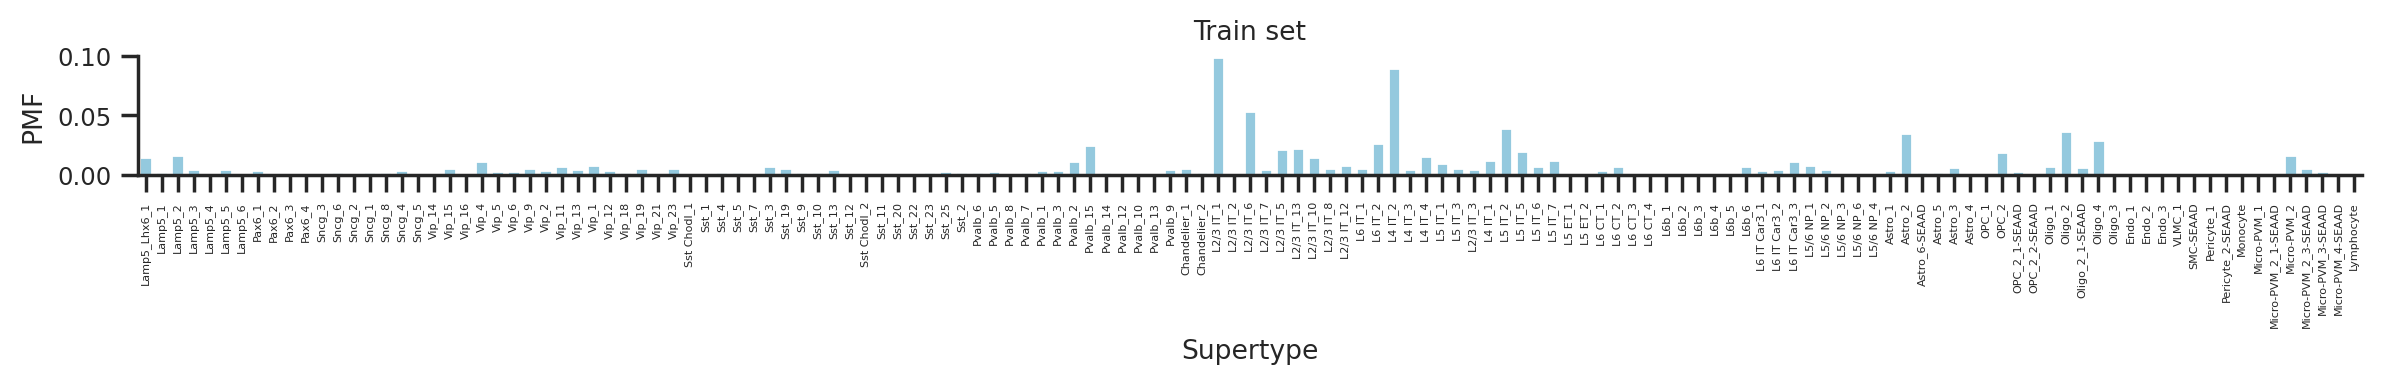

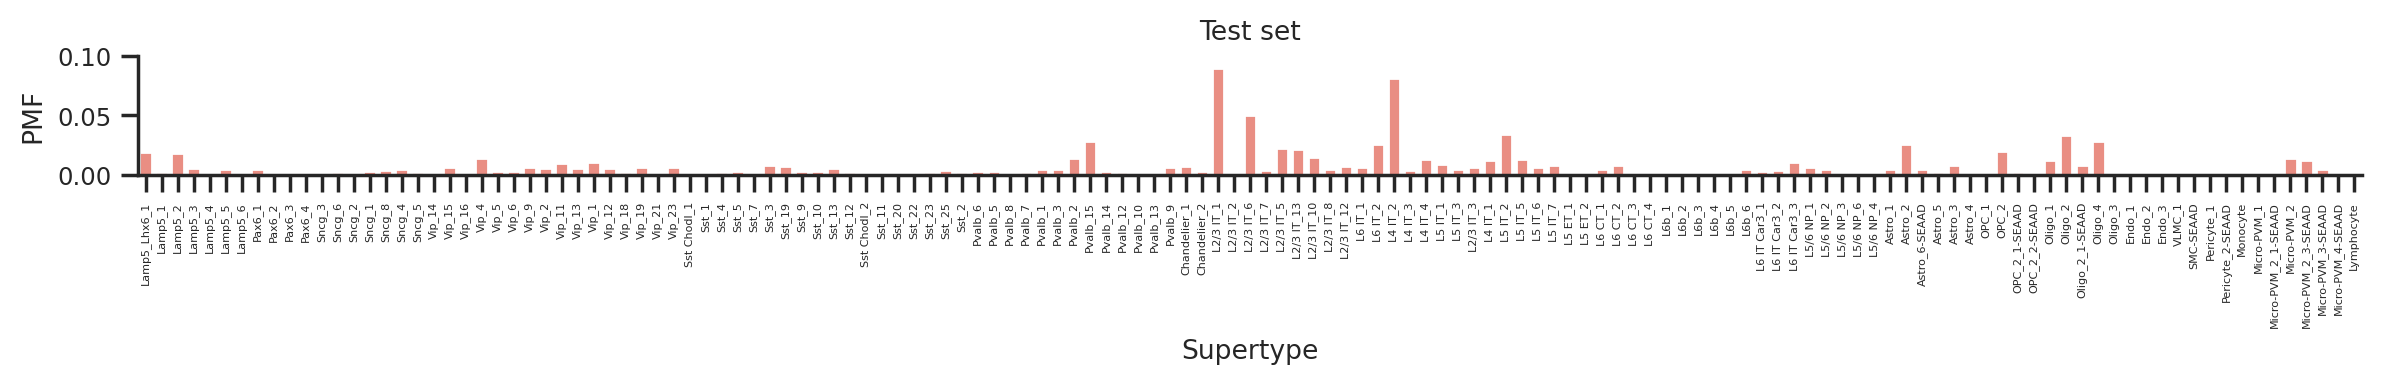

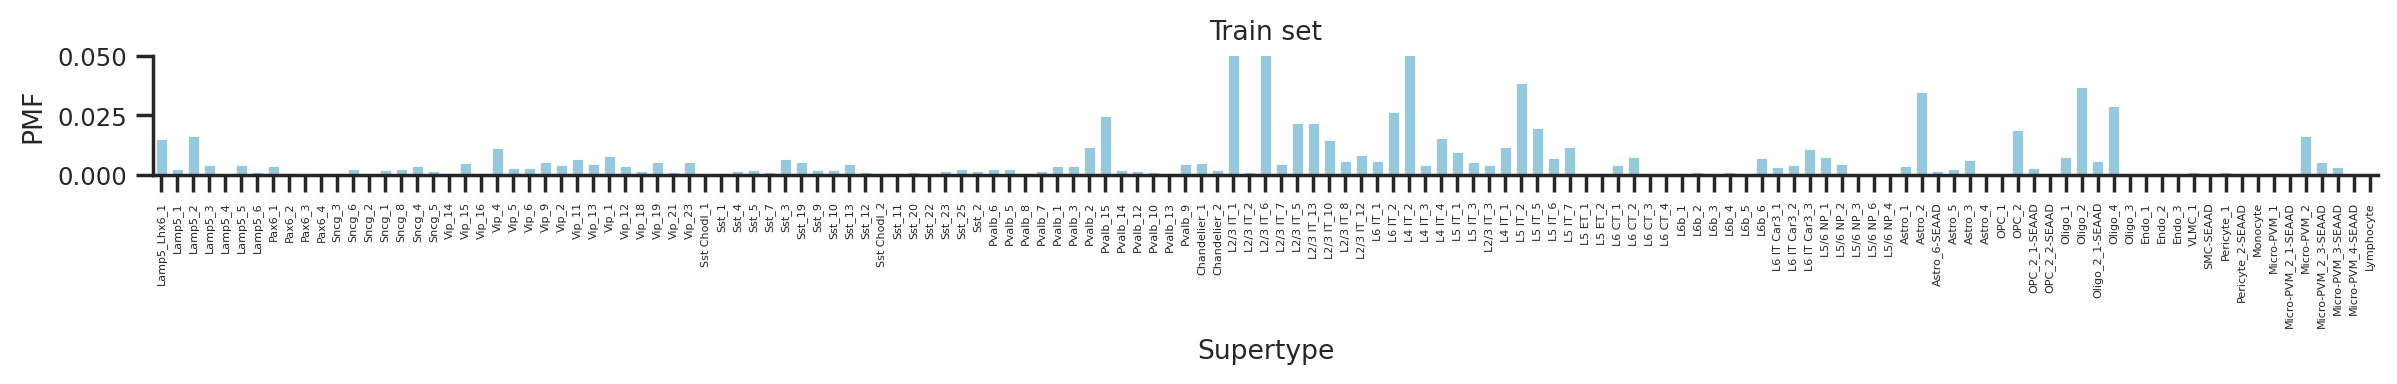

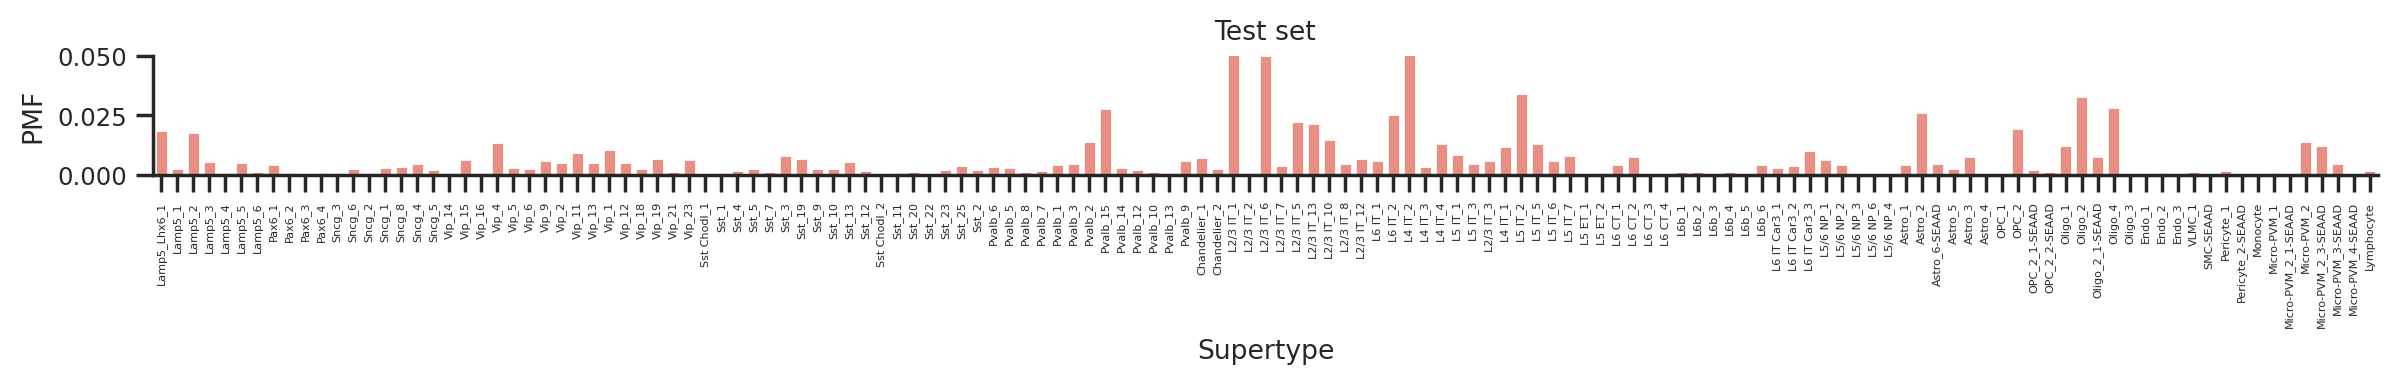

In [11]:
# show supertype distribution in train and test set

adata_train = adata_[train_idx]
adata_test = adata_[test_idx]

for this_ylim in [[0, 0.1], [0, 0.05]]:
    df_train = adata_train.obs["Supertype"].value_counts().to_frame()
    df_train = df_train.reindex(adata_.obs["Supertype"].cat.categories)
    df_train["pmf"] = df_train["count"] / df_train["count"].sum()
    df_train = df_train.reset_index().rename(columns={"index": "Supertype"})

    f, ax = plt.subplots(figsize=(12, 2))
    sns.barplot(data=df_train, x="Supertype", y="pmf", ax=ax, color="skyblue")
    ax.set(ylabel="PMF", title="Train set", ylim=this_ylim)
    plt.xticks(rotation=90, fontsize=4)
    plt.tight_layout()
    plt.show()

    df_test = adata_test.obs["Supertype"].value_counts().to_frame()
    df_test = df_test.reindex(adata_.obs["Supertype"].cat.categories)
    df_test["pmf"] = df_test["count"] / df_test["count"].sum()
    df_test = df_test.reset_index().rename(columns={"index": "Supertype"})

    f, ax = plt.subplots(figsize=(12, 2))
    sns.barplot(data=df_test, x="Supertype", y="pmf", ax=ax, color="salmon")
    ax.set(xlabel="Supertype", ylabel="PMF", title="Test set", ylim=this_ylim)
    plt.xticks(rotation=90, fontsize=4)
    plt.tight_layout()
    plt.show()

In [12]:
# testing function donor_split which will be used in scripts.

from schelp.utils.data import donor_split

train_idx_, test_idx_ = donor_split(obs=adata_.obs, donor_frac_pergroup=0.15)

assert np.array_equal(train_idx, train_idx)
assert np.array_equal(test_idx, test_idx)

High supertype entropy donors make up 13.50% of total cells
Train set: 86.50%
Test set: 13.50%


In [13]:
# print number of cells in test and train
print(f"Train set: {train_idx_.shape[0]} cells")
print(f"Test set: {test_idx_.shape[0]} cells")

Train set: 1061187 cells
Test set: 165668 cells


In [14]:
df_test = adata_test.obs[["Overall AD neuropathological Change", "Donor ID"]]
df_test = df_test.drop_duplicates().groupby("Overall AD neuropathological Change").count()
display(df_test)

df_train = adata_train.obs[["Overall AD neuropathological Change", "Donor ID"]]
df_train = df_train.drop_duplicates().groupby("Overall AD neuropathological Change").count()
display(df_train)

,Donor ID
Overall AD neuropathological Change,
Not AD,1
Low,1
Intermediate,3
High,6


,Donor ID
Overall AD neuropathological Change,
Reference,5
Not AD,8
Low,11
Intermediate,18
High,36
